# **Milestone 3: Sources, Forms, and Quantification of Bias and Discrimination in Supervised Learning**
## **PRACTICE NOTEBOOK 4 - Example code to get confidence intervals for a metric**


In this part of the course, we will look for bias using a practical example. A  company is looking to hire a new employee. They use a machine learning algorithm to select the top candidates. The candidates are assigned either 0 if they're not selected or 1 if they are. 

There are 4 practice notebooks in total (current one in red):
1. Explore given data to: detect potential bias early & check for proxies 
2. Evaluate model bias "manually"
3. Evaluate model bias using existing libraries (aif360)
4. <font color='red'> **Example code to get confidence intervals for a metric (nothing to do)**</font>

Instructions to complete in each parts are in bold. Intermediate results are given so one can continue the exercise. 

This is notebook number 4. As stated at the end of the previous notebook, so far, we only obtained one number for fairness metrics. In a real life setting, you should calculate a confidence interval by repeating the experiments for different train/test splits. A way to do this is for instance to use a non-parametric bootstrap method as described in section 10.2 from the book [Computer Age Statistical Inference by B.Efron and T.Hastie](https://web.stanford.edu/~hastie/CASI_files/PDF/casi.pdf) that we linked earlier. We give an example of this in the next and last notebook. Note that there will be nothing for you to do in this last notebook. 

## **0 - Import modules, load data and useful functions**

In [ ]:
!pip install aif360 #install aif360

     |████████████████████████████████| 175 kB 14.6 MB/s 
     |████████████████████████████████| 356 kB 54.8 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30190 sha256=3b5fa49697dc23b0700089601fd8db9a6b5a4a6fc63ec981f5a5acf69a79044c
  Stored in directory: /root/.cache/pip/wheels/56/19/d5/8cad06661aec65a04a0d6785b1a5ad035cb645b1772a4a0882
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491647 sha256=9a6aaae30dfebde3cfb5cc75b8833a4c7ffbffb238dfbc1796315f44d110943b
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built memory-profiler shap


In [ ]:
#imports 
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
import aif360
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset

In [ ]:
# Only run if running on Google Colab
!pip3 install pickle5
import pickle5 as pickle
!gdown --id 1-Wd1evAoDs4YsjRLfC-ifarmQL-Ozg3R # download data file from public link and place it in content/ folder

     |████████████████████████████████| 132 kB 15.4 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219300 sha256=11e996315936569e520949cdf21e785493f626e104fbd7be1ba83aa592c81440
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5
Downloading...
From: https://drive.google.com/uc?id=1-Wd1evAoDs4YsjRLfC-ifarmQL-Ozg3R
To: /content/data.pickle
128MB [00:00, 188MB/s]


In [ ]:
'''
Uncomment the code below if you are running this from your local machine
Note: Place data.pickle file in the same folder as the .ipynb notebook (Download link: https://docs.google.com/uc?export=download&id=1-Wd1evAoDs4YsjRLfC-ifarmQL-Ozg)
'''
# with open('data.pickle', 'rb') as handle:
#     raw_data = pickle.load(handle)   
if 'google.colab' in str(get_ipython()): # if running from colab
  with open('/content/data.pickle', 'rb') as handle:
      raw_data = pickle.load(handle)  
raw_data[:5] #display the first 5 candidates data

,Label,Gender,Ethnicity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,0,Female,White,28.021737,4.351153,2.453895,1.637143,-1.746628,-0.483463,0.034170,1.399225,-0.795440,0.417474,0.214564,-0.471581,1.945645,-0.676217,1.213878,0.015701,1.472670,-0.054158,0.106858,-1.073194,-1.071848,-0.249942,0.634626,-0.732358,2.445728,0.784284,0.112329,1.055362,-0.605459,1.259140,-0.287927,0.214142,-0.644585,1.165376,-0.409198,-0.705823,0.091147,...,-0.655416,-0.012623,0.660826,0.258141,0.036875,-0.229340,0.353817,-0.178814,-0.145229,-0.040692,-0.046980,0.311939,-0.348202,0.271357,0.355443,-0.050447,-0.051816,0.083028,0.184139,0.107824,-0.083415,-0.359288,0.156547,-0.588539,-0.025777,-0.172269,0.331421,0.222768,-0.319124,-0.060476,-0.557444,-0.015627,-0.052749,-0.234189,-0.072384,0.090403,0.376761,0.258914,-0.050558,0.014513
1,0,Female,White,29.603342,-3.407193,0.771800,-2.957411,0.599226,-2.805277,0.329414,-2.055339,-1.194446,-0.633159,2.268302,1.159443,0.899266,-0.472739,0.541605,-1.248643,0.046512,1.225688,0.456477,-1.483071,-0.944882,1.483229,0.512809,0.692537,0.178988,-1.609531,-1.985852,-0.469491,-1.156583,0.475535,-0.041015,-0.214832,-0.681641,1.131433,-0.667814,0.267111,-0.112433,...,0.034605,-0.024487,-0.212205,0.440684,-0.065303,0.409878,0.455144,-0.108402,0.027760,-0.015238,0.027453,0.319960,-0.014589,-0.083241,-0.285702,0.047510,-0.144107,0.405289,-0.044139,-0.287215,0.201876,-0.298703,0.347969,0.029646,0.073052,-0.010259,0.023681,0.373202,-0.525402,-0.198727,-0.198440,-0.158843,0.191984,-0.004532,0.229210,-0.173042,-0.072871,0.442939,-0.054423,0.026959
2,1,Female,Hispanic,26.504283,0.642464,2.522944,-2.197094,2.270646,-0.472510,0.532815,-0.266449,-0.131638,1.038315,-0.865827,-0.811267,-0.381401,-0.801701,-0.485021,0.656005,2.489571,-0.714447,0.658228,-0.075957,-1.159888,-2.334786,-0.253364,-2.073697,-0.939994,-1.177166,0.551689,-1.313316,-0.486217,0.732130,-0.320456,-1.143053,1.297522,-0.617038,0.340978,0.978603,0.398515,...,0.510825,-0.616479,0.644675,0.505319,-0.299894,-0.058435,0.095024,-0.101136,0.042583,0.061005,0.304137,0.259210,-0.022425,0.138097,-0.442536,-0.108350,0.369865,0.151049,0.096285,0.013651,0.175281,0.144344,-0.006250,0.100850,-0.051642,0.122977,-0.088661,-0.229844,-0.272144,0.012633,0.423352,-0.033844,-0.125387,-0.483924,-0.116553,-0.113281,0.015519,0.017111,-0.012309,0.264572
3,0,Female,Hispanic,25.012088,0.895121,-2.092517,3.687830,0.539642,1.988930,1.121646,2.255337,-0.128801,1.148379,1.616247,-2.599757,-0.322807,2.102508,-0.204551,0.069818,0.745222,-0.859875,-2.235995,-0.207436,-1.678697,-0.569024,-0.723122,-0.144833,-1.537487,1.678429,0.501249,-0.230747,0.746559,-0.069959,-0.346651,0.448291,0.283592,-0.445759,-0.529080,0.287333,0.466766,...,-0.153845,-0.049137,-0.023112,-0.173509,-0.265363,0.091898,0.016743,-0.092894,-0.009915,-0.031731,0.153983,0.001281,0.123019,-0.035719,-0.045633,-0.103204,0.089567,0.104990,0.337228,-0.018783,-0.215437,0.268139,-0.125425,0.095183,-0.125172,-0.226467,0.371647,-0.023041,-0.093040,0.338300,-0.280392,0.046582,0.116709,0.133876,0.072716,0.124083,0.213735,-0.149901,-0.217130,0.004403
4,1,Male,Hispanic,27.358934,-2.332423,0.154999,-2.623793,1.682456,1.262280,-1.685565,0.489319,-0.043471,-0.372265,1.778535,-1.145419,2.461327,1.396318,-0.911969,-2.228570,1.378633,-1.512325,-0.440331,-0.111163,-0.885884,-0.840501,1.576620,-0.972075,-2.008346,-0.358732,0.896535,0.562193,0.154542,-1.077315,1.902062,1.728109,0.317205,-0.436143,0.226549,-0.502206,-0.157102,...,0.181831,-0.026589,-0.051453,0.261819,-0.048644,-0.099526,-0.026777,0.039836,-0.168277,0.077232,0.193722,0.093298,-0.075132,-0.063202,0.120167,0.039270,0.350429,0.166559,0.130134,-0.181019,-0.193276,0.312204,-0.187331,-0.029194,-0.212277,-0.463872,0.041810,0.041185,-0.182479,-0.182461,-0.019350,-0.093371,0.0034

In [ ]:
# remove all nans --> we use the variable "data" in the rest of this notebook
data = raw_data.dropna()

In [ ]:
def split_data_from_df(data):
  y = data['Label'].values
  # g = data['Gender'].values
  # e = data['Ethnicity'].values
  X = data[np.arange(500)].values
  filter_col = ['Ethnicity','Gender'] + [col for col in data if str(col).startswith('Ethnicity_')] + [col for col in data if str(col).startswith('Gender_')] 
  dem = data[filter_col].copy()
  return X,y,dem
def encode(df):
  g_enc = LabelEncoder()
  e_enc = LabelEncoder()
  df['Gender'] = g_enc.fit_transform(df['Gender'])
  df['Ethnicity'] = e_enc.fit_transform(df['Ethnicity'])
  return df, g_enc,e_enc

## **2. An example using non-parametric bootstrap to get a confidence interval**

Let's demonstrate how we can get a confidence interval for metrics using bootstrap sampling in this section. All the code is provided and there is nothing to do.

The steps are:

1. We define two helper functions that calculate performance and fairness metrics.
2. We define the number of iterations (100 here), the unprivileged and privileged groups (Black vs White)
3. For each iteration we:
 - create a bootstrap sample of the data (sample the data with replacement). This sample is used as training data. Because we sample with replacement, some original data points will be present several times and some will not be there at all. As a rule of thumb, about a third of the original data is not selected. We use this as the test set to evaluate metrics.
  - calculate the performance and fairness metrics using the pre-defined functions.
4. We then display the mean and standard deviation for each metric, and plot an histogram for Disparate Impact
A 90% confidence interval can be for instance obtained by using the 5th and 95th percentiles of the obtained values as the lower and upper limits.

In [ ]:
import sklearn.metrics as metrics
from tqdm.notebook import tqdm
def get_perf_metrics(y_true,y_pred):
    # setup the performance metrics to be computed
    perf_metrics = {"Accuracy": metrics.accuracy_score(y_true,y_pred), 
                "Precision": metrics.precision_score(y_true,y_pred), 
                "Recall": metrics.recall_score(y_true,y_pred), 
                "F1-Score": metrics.f1_score(y_true,y_pred), 
                }
    met = []
    for pf in perf_metrics.keys():
            met += [[pf, perf_metrics[pf]]]
    
    df = pd.DataFrame(met, columns=["Metric", "Value"])
    return df
def get_fair_metrics(df_data,y_pred,privileged_groups,unprivileged_groups):
    # create true and pred BinaryLabelDatasets
    ds_data_true = BinaryLabelDataset(favorable_label=1.0, unfavorable_label=0.0,df=df_data,label_names=['Label'],protected_attribute_names=['Gender','Ethnicity'])
    X_data,y_data,dem_data = split_data_from_df(df_data)
    ds_data_true.features = X_data
    ds_data_true.feature_names = np.arange(500).astype(str)
    ds_data_pred = ds_data_true.copy()
    ds_data_pred.labels = y_pred
    # create matrics object
    fair_metrics = ClassificationMetric(
        ds_data_true, ds_data_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
    # get metrics of interest
    met = []
    met += [['Statistical Parity Difference', fair_metrics.statistical_parity_difference()]]
    met += [['Disparate Impact', fair_metrics.disparate_impact()]]
    met += [['Equal Opportunity Difference (True Positive Rate Difference)', fair_metrics.equal_opportunity_difference()]]
    met += [['False Positive Rate Difference', fair_metrics.false_positive_rate_difference()]]
    met += [['Average Odds Difference', fair_metrics.average_odds_difference()]]
    df = pd.DataFrame(met, columns=["Metric", "Value"])
    return df

In [ ]:
# settings
n_iter = 100
unprivileged_groups = [{'Ethnicity':1}]  #1 is the code for 'Black'
privileged_groups = [{'Ethnicity':3}]   #3 is the code for 'White 
# make Gender and Ethnicity numerical
data_enc,_,_ = encode(data.copy())
#loop
for i in tqdm(range(n_iter)):
    # sample with replacement
    idx_bootsample = np.random.choice(range(len(data)), size=len(data), replace=True)
    df_train = data_enc.iloc[idx_bootsample].copy() 
    X_train,y_train,_ = split_data_from_df(df_train)
    # train on bootsample
    model = RidgeClassifier()
    model.fit(X_train,y_train)
    # test on remaining indexes (not selected by bootsample ~ 1/3 of total)
    idx_test = np.array([i for i in range(len(data)) if i not in idx_bootsample])
    df_test = data_enc.iloc[idx_test].copy() 
    X_test,y_test,_ = split_data_from_df(df_test)
        # predict on test set
    y_pred_test = model.predict(X_test)
        # get perf metrics
    met_perf = get_perf_metrics(y_test,y_pred_test)
        # get fairness metrics
    met_fair = get_fair_metrics(df_test,y_pred_test,privileged_groups,unprivileged_groups)
    # concatenate all results in one dataframe
    met= pd.concat([met_perf, met_fair], axis=0, ignore_index=True)
    met['Iteration'] = i
    if i==0:
        df_metrics = met.copy()
    else:
        df_metrics = pd.concat([df_metrics, met.copy()], axis=0, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Display metrics
metrics_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table

,mean,std
,Value,Value
Metric,,
Accuracy,0.708415,0.003593
Average Odds Difference,-0.077294,0.012635
Disparate Impact,0.754069,0.032447
Equal Opportunity Difference (True Positive Rate Difference),-0.102419,0.021557
F1-Score,0.585280,0.005863
False Positive Rate Difference,-0.052169,0.013032
Precision,0.645119,0.008497
Recall,0.535743,0.009431


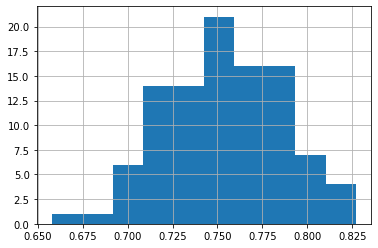

In [ ]:
# plot disparate impact metric distribution
df_metrics[df_metrics['Metric']=='Disparate Impact'].Value.hist()